# Q-learning Convergence : Simulation


The goal of this notebook is to show why the assumptions in the article (Convergence of Stochastic Iterative
Dynamic Programming Algorithms) are very determinant in some cases (we give examples of three games: Black Jack, Cliff Walking, and Grid World. Note that all mentions of 'report' will only refer to our reinforcement learning project report and all those for paper or article will strictly be referring to ''Convergence of Stochastic Iterative Dynamic Programming Algorithms''.

To do so we define $\eta (t) \, = \, \underset{s \in S,\,u \in A}{max} \, |Q_{t+1}(s,u) - Q_{t}(s,u)| \,$,   where $Q_t (s,u)$ is defined by the value of $Q(s,u)$ at the step $t$ of the algorithm (please check our report part 3 Q-learning simulation), $S$ the set of states and $A$ that of actions.

Indeed if we have convergence we would have $\eta (t) \xrightarrow{t \rightarrow \infty}{ 0}  $

In [1]:
!pip install gym

  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657520 sha256=4633ad70b7dc9e80815b44c17b58643fc80b3946f817d3f0eeb13f1f8f5471ed
  Stored in directory: c:\users\hadamard\appdata\local\pip\cache\wheels\b3\03\54\9141c232861b89be935b37bdde0ea5ab472f5e18fc20623aed
Successfully built gym


In [2]:
%matplotlib inline

#import python key packages
import gym
import itertools
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib


#add path to import libs
if "../" not in sys.path:
  sys.path.append("../") 

#defaultdict
from collections import defaultdict

#import games 
from lib.envs.blackjack import BlackjackEnv
from lib.envs.cliff_walking import CliffWalkingEnv
from lib.envs.gridworld import GridworldEnv

#use ggplot style while ploting
matplotlib.style.use('ggplot')

# Games

In [3]:
#define your games
env1 = BlackjackEnv()
env2 = CliffWalkingEnv()
env3 = GridworldEnv()

# Greedy policy and max norm

In [4]:
#epsilon greedy function, we may follow literally the algorithm in the paper by setting epsilon at 0. However, that does not 
#change a great deal the results whenever epsilon is constant

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

#function that computes eta given the absolute value of the difference between Q(t+1) and Q(t)
def sup(diff_Q):
    value = 0
    for i in diff_Q:
        temp = max(diff_Q[i])
        if value < temp:
            value = temp
    return value

# Article assumptions for convergence (Theorem 2)

First of all, it is somehow obvious that choosing $\gamma \geq 1$ may not be very relevant. Indeed if you consider a model where the award $c_s(u) > c > 0$ whatever $s$ and $u$, then the value $Q(s,u)$ is infinite whatever the strategy we make. As this may bring a lot of complexity to our work we will assume that $\gamma < 1$.

With that being said, we will try to visualise how important the assumption on $\{\alpha_t\}_{t \in \mathbb{N}}$ is (The assumption is : $\underset{t}{\sum} \alpha_t = + \infty$ and $\underset{t}{\sum} \alpha_t^2 < + \infty$). First we draw the evolution of $\eta$ with respect to t, considering that $\alpha $ is constant, thus does not comply with that assumption.

### $\alpha$ not satisfying the condition of the article


In [5]:
def q_learning_no_alpha_square_conv(env, num_episodes, discount_factor=0.9, alpha=0.5, epsilon=0.1):
    
    
    """
    1st case : alpha does not comply with the assumption as on the paper
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate. (taken constant)
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
 
    
    #Track delta History eta_t
    eta = defaultdict(lambda: np.zeros(env.action_space.n))
    unif_sup_eta_history = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # TD and eta history Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            last_value = Q[state][action]
            Q[state][action] = alpha * td_delta
            eta[state][action] = np.abs(Q[state][action] - last_value)
            unif_sup_eta_history.append(sup(eta))
            
            
            if done:
                break
                
            state = next_state
    
    return Q, unif_sup_eta_history

Episode 10000/10000.

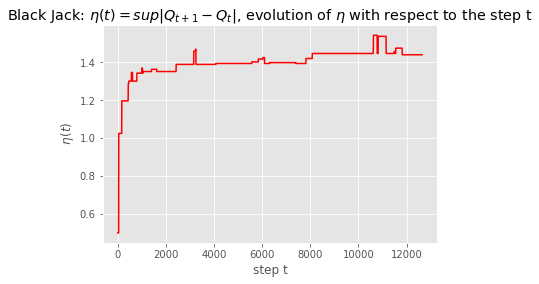

In [6]:
Q1, unif_sup_eta_history1 = q_learning_no_alpha_square_conv(env1, 10000)
plt.figure('Black Jack : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.plot(np.arange(len(unif_sup_eta_history1)),unif_sup_eta_history1, color='r')
plt.xlabel('step t')
plt.ylabel(' $\eta (t)$ ')
plt.title('Black Jack: $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.show()



Episode 10/10.

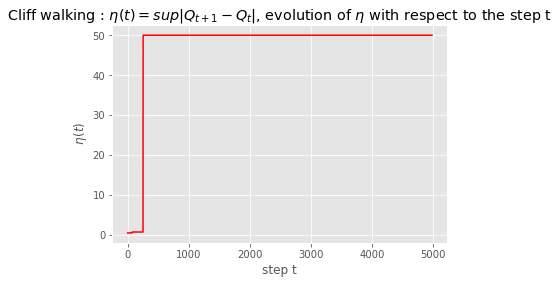

In [7]:
Q2, unif_sup_eta_history2 = q_learning_no_alpha_square_conv(env2, 10)
plt.figure('Cliff walking : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.plot(np.arange(len(unif_sup_eta_history2)),unif_sup_eta_history2, color='r')
plt.xlabel('step t')
plt.ylabel(' $\eta (t)$ ')
plt.title('Cliff walking : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.show()

Episode 10000/10000.

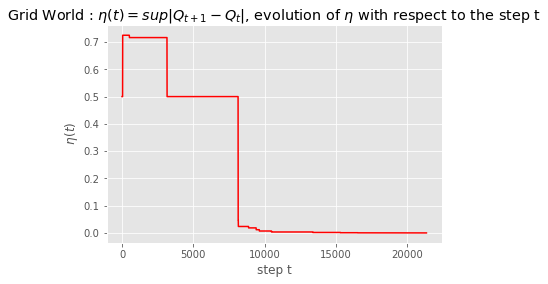

In [8]:
Q3, unif_sup_eta_history3 = q_learning_no_alpha_square_conv(env3, 10000)
plt.figure('Grid World : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.plot(np.arange(len(unif_sup_eta_history3)),unif_sup_eta_history3, color='r')
plt.xlabel('step t')
plt.ylabel(' $\eta (t)$ ')
plt.title('Grid World : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.show()

For the three figures above, we took $\alpha = constante = 0.5$. We notice that there has been qualitatively only one possible case: Grid World. This means that the assumption on $\alpha$ (as in the article) may help bring the process to convergence at the infinity in the general case.

Next, we will see how things change, when $\alpha$ complies with the condition (2) in the paper.

### $\alpha$ satisfying the condition 2 (article)

In [9]:
def q_learning_alpha_square_conv(env, num_episodes, discount_factor=0.9, epsilon=0.1):
    
    
    """
    alpha(t) = 1/t (Sum of 1/t = infinity and Sum of 1/(t^2) < infinity)
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    
    #Track delta History eta_t
    eta = defaultdict(lambda: np.zeros(env.action_space.n))
    unif_sup_eta_history = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    #counter for steps k : t in the article and the report
    k=1.
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            
            # TD and eta history Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            last_value = Q[state][action]
            Q[state][action] += (1./k) * td_delta
            eta[state][action] = np.abs(Q[state][action] - last_value)
            unif_sup_eta_history.append(sup(eta))
            k += 1
            
            
            if done:
                break
                
            state = next_state
    
    return Q,  unif_sup_eta_history

Episode 10000/10000.

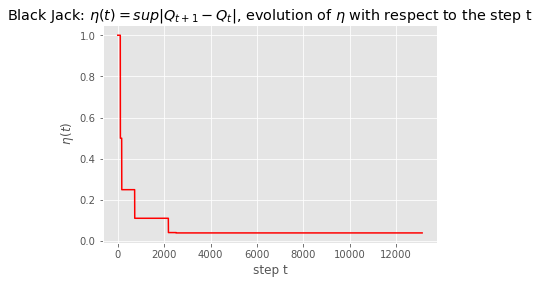

In [10]:
Q1,  unif_sup_eta_history1 = q_learning_alpha_square_conv(env1, 10000)
plt.figure('Black Jack : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.plot(np.arange(len(unif_sup_eta_history1)),unif_sup_eta_history1, color='r')
plt.xlabel('step t')
plt.ylabel(' $\eta (t)$ ')
plt.title('Black Jack: $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.show()



Episode 1000/1000.

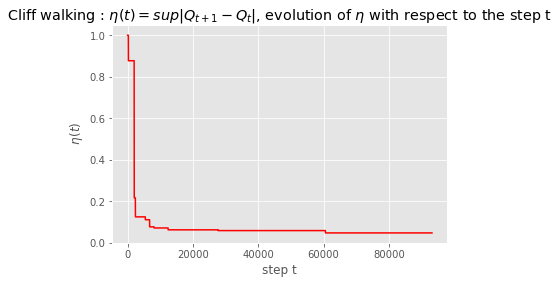

In [11]:
Q2, unif_sup_eta_history2 = q_learning_alpha_square_conv(env2, 1000)
plt.figure('Cliff walking : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.plot(np.arange(len(unif_sup_eta_history2)),unif_sup_eta_history2, color='r')
plt.xlabel('step t')
plt.ylabel(' $\eta (t)$ ')
plt.title('Cliff walking : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.show()

Episode 1000/1000.

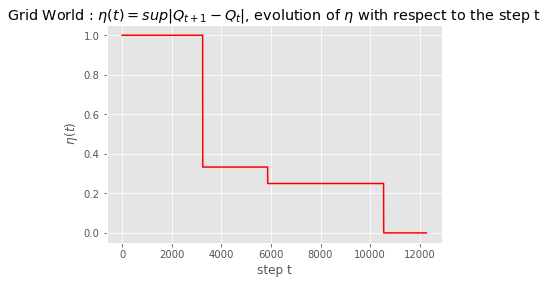

In [12]:
Q3, unif_sup_eta_history3 = q_learning_alpha_square_conv(env3, 1000)
plt.figure('Grid World : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.plot(np.arange(len(unif_sup_eta_history3)),unif_sup_eta_history3, color='r')
plt.xlabel('step t')
plt.ylabel(' $\eta (t)$ ')
plt.title('Grid World : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.show()

The three figures right above, in contrast of first case, things seem coherent with the theoritical result as the error $\eta$ visually converges to 0. This means that in this case (taking $\alpha = \frac{1}{t}$) $Q(t)$ define a Cauchy sequence that converges which means that it converges.

However, as we are dealing with random process, we would generate several of the them (say 20) and see if $\mathbb{P}(\underset{t \rightarrow \infty}{lim} Q_t = Q^{*})$ holds empirically. We do this for the Black Jack.

### Almost sure convergence

Episode 1000/1000.

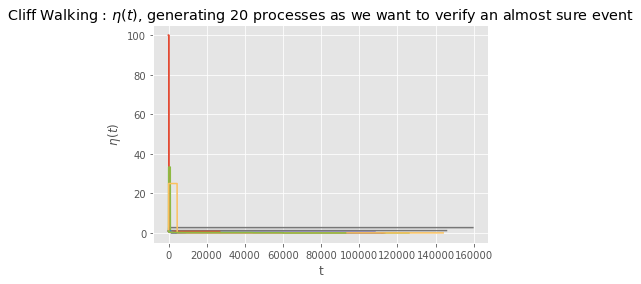

In [13]:
plt.figure('Almost sure event')
nb_process = 20
for i in range(nb_process):
    Q2, unif_sup_eta_history2 = q_learning_alpha_square_conv(env2, 1000)
    plt.plot(np.arange(len(unif_sup_eta_history2)),unif_sup_eta_history2)
    
plt.xlabel('t')
plt.ylabel(' $\eta (t)$ ')
plt.title('Cliff Walking : $\eta (t) $, generating {} processes as we want to verify an almost sure event'.format(nb_process))
plt.show()

All the processes seem to converge to 0 as $t$ goes to infinity. As there seemingly is no single process that presents a sharp drift from the event of convergence for big values of $t$, one may say that the numerical results are coherent with the theoretical ones.

### variance of reward condition

Now we want to see what would happen if the third condition of the article (theorem 2) is not satisfied.

We define a new function for the best case, which means all conditions mentioned in theorem 2 are satisfied except the third.

In [14]:
def q_learning_no_3(env, num_episodes,func, discount_factor=0.9, epsilon=0.1):
    
    
    """
    alpha(t) = 1/t (Sum of 1/t = infinity and Sum of 1/(t^2) < infinity) complies with the second condition of theorem 2
    third condition not satisfied
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
   
    
    #Track delta History eta_t
    eta = defaultdict(lambda: np.zeros(env.action_space.n))
    unif_sup_eta_history = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    #counter for steps k : t in the article and the report
    k=1.
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            
            # TD and eta history Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = (reward * func(k)) + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            last_value = Q[state][action]
            Q[state][action] += (1./k) * td_delta
            eta[state][action] = np.abs(Q[state][action] - last_value)
            unif_sup_eta_history.append(sup(eta))
            k += 1
            
            
            if done:
                break
                
            state = next_state
    
    return Q,  unif_sup_eta_history

Episode 1000/1000.

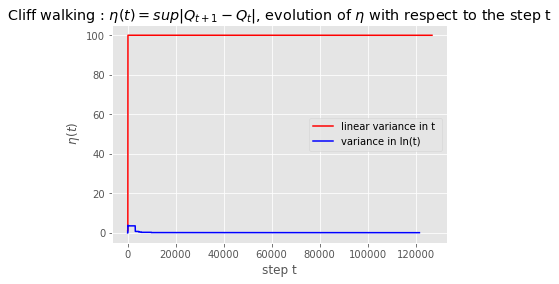

In [15]:
Q1,  unif_sup_eta_history1 = q_learning_no_3(env2, 1000,np.log)
Q2,  unif_sup_eta_history2 = q_learning_no_3(env2, 1000,np.abs)

plt.figure('Cliff walking : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.plot(np.arange(len(unif_sup_eta_history2)),unif_sup_eta_history2, color='r', label='linear variance in t ')
plt.plot(np.arange(len(unif_sup_eta_history1)),unif_sup_eta_history1, color='b', label='variance in ln(t) ')
plt.xlabel('step t')
plt.ylabel(' $\eta (t)$ ')
plt.title('Cliff walking : $\eta (t) = sup|Q_{t+1} - Q_t|$, evolution of $\eta$ with respect to the step t')
plt.legend()
plt.show()

From the figure above, we see that in general, the lack of the third condition may get things a little more complicated in terms of convergence, well, at least numerically.